/var/folders/w8/pgm7hpw171qc1gwzhhq42jwc0000gn/T/ipykernel_23160/3533170092.py:79: RuntimeWarning: overflow encountered in exp
  acc = np.exp(like_ratio + prior_ratio - proposal)
/var/folders/w8/pgm7hpw171qc1gwzhhq42jwc0000gn/T/ipykernel_23160/3533170092.py:46: RuntimeWarning: overflow encountered in exp
  acc = np.exp(like_ratio + prior_ratio)


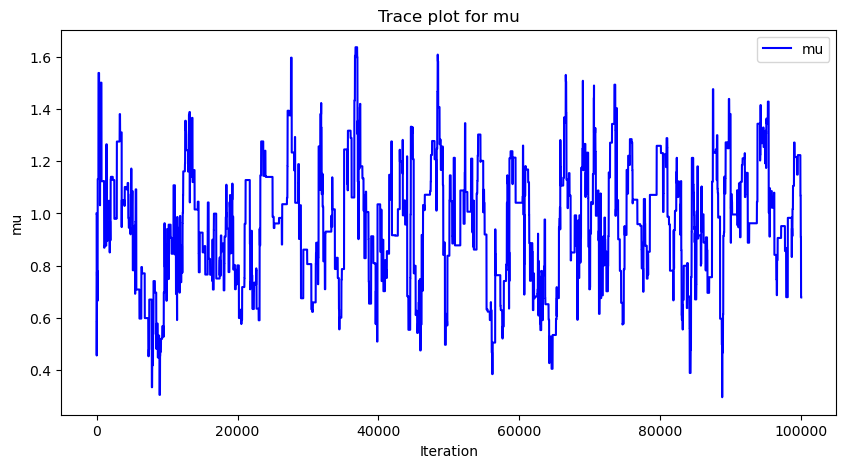

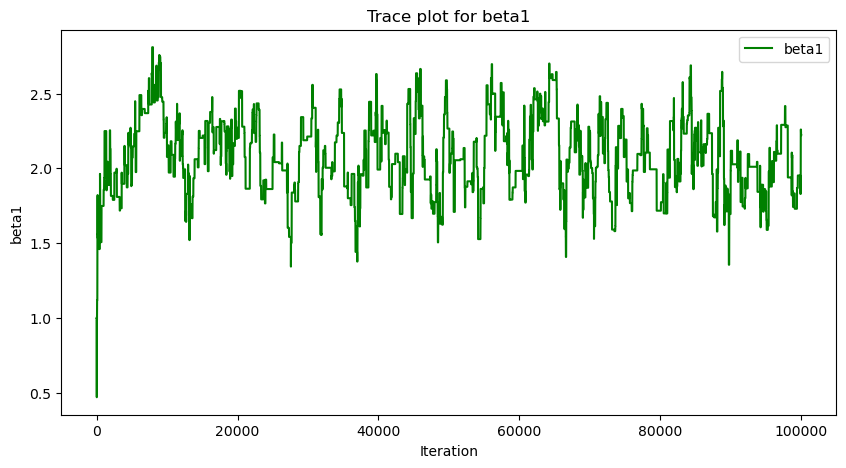

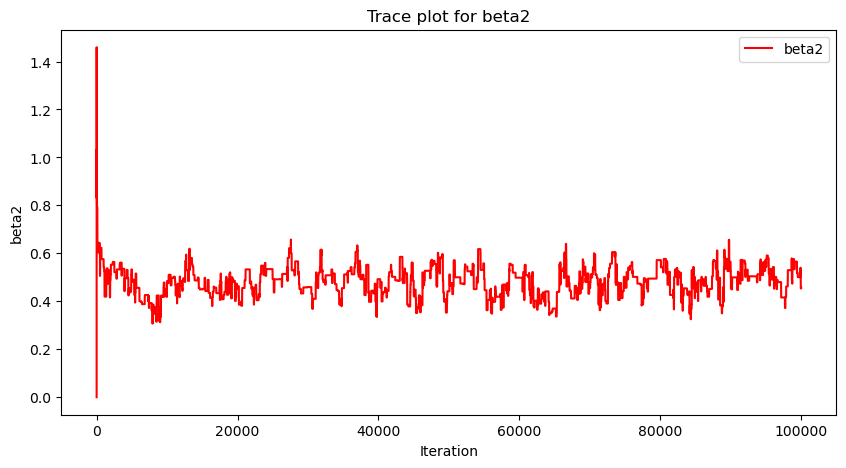

Estimated P(m=1): 1e-05


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seed
np.random.seed(123)

# Generate data
x1 = np.arange(1, 10.05, 0.05)
x1 = x1 / np.std(x1)  # Standardize x1
x2 = x1 ** 2  # Quadratic term

sig = np.sqrt(0.5)
y = np.random.normal(loc=1 + 2*x1 + 0.5*x2, scale=sig, size=len(x1))

# Initialize parameters
n_mc = 100000
m = np.ones(n_mc, dtype=int)  # Model indicator (1 or 2)
h = np.array([[0.5, 0.5], [0.5, 0.5]])  # Transition probabilities between models

beta01 = np.zeros((n_mc, 2))  # Stores mu and beta1
beta2 = np.zeros(n_mc)  # Stores beta2

# Prior parameters
sig_u = np.sqrt(1)
sig_beta = np.sqrt(10)
pi_M = 0.5  # Prior probability P(m=1)
tau = np.sqrt(0.05)  # Variance of proposal density

# Initial values
m[0] = 1
beta01[0] = [1, 1]

# Full model sampling function
def samp012(b01, b2):
    curr = np.array([b01[0], b01[1], b2])
    epi = np.random.normal(0, tau, size=3)
    prop = curr + epi

    like_ratio = -np.sum(np.log(norm.pdf(y, loc=curr[0] + curr[1]*x1 + curr[2]*x2, scale=sig))) + \
                 np.sum(np.log(norm.pdf(y, loc=prop[0] + prop[1]*x1 + prop[2]*x2, scale=sig)))

    prior_ratio = -np.sum(np.log(norm.pdf(curr, loc=0, scale=sig_beta))) + \
                  np.sum(np.log(norm.pdf(prop, loc=0, scale=sig_beta)))

    acc = np.exp(like_ratio + prior_ratio)
    ind = np.random.uniform(0, 1) < acc
    return prop if ind else curr

# Reduced model sampling function
def samp01(b01):
    curr = np.array([b01[0], b01[1]])
    epi = np.random.normal(0, tau, size=2)
    prop = curr + epi

    like_ratio = -np.sum(np.log(norm.pdf(y, loc=curr[0] + curr[1]*x1, scale=sig))) + \
                 np.sum(np.log(norm.pdf(y, loc=prop[0] + prop[1]*x1, scale=sig)))

    prior_ratio = -np.sum(np.log(norm.pdf(curr, loc=0, scale=sig_beta))) + \
                  np.sum(np.log(norm.pdf(prop, loc=0, scale=sig_beta)))

    acc = np.exp(like_ratio + prior_ratio)
    ind = np.random.uniform(0, 1) < acc
    return prop if ind else curr

# RJMCMC Algorithm
for sim in range(n_mc - 1):
    if m[sim] == 1:
        chg_ind = np.random.uniform(0, 1) < h[0, 1]
        
        if chg_ind:
            u = np.random.normal(0, sig_u)
            beta2_tmp = u

            like_ratio = -np.sum(-2 * beta2_tmp * x2 * (y - beta01[sim, 0] - beta01[sim, 1] * x1) + beta2_tmp**2 * x2**2) / (2 * sig**2)
            prior_ratio = -np.log(np.sqrt(2 * np.pi) * sig_beta) - beta2_tmp**2 / (2 * sig_beta**2)
            proposal = - (np.log(np.sqrt(2 * np.pi) * sig_u) - u**2 / (2 * sig_u**2))

            acc = np.exp(like_ratio + prior_ratio - proposal)
            ind = np.random.uniform(0, 1) < acc
            
            if ind:
                m[sim+1] = 2
                beta2[sim+1] = beta2_tmp
                beta01[sim+1] = beta01[sim]
            else:
                m[sim+1] = m[sim]
                beta2[sim+1] = 0
                beta01[sim+1] = beta01[sim]
        
        else:
            beta01[sim+1] = samp01(beta01[sim])
            beta2[sim+1] = 0
            m[sim+1] = m[sim]

    if m[sim] == 2:
        chg_ind = np.random.uniform(0, 1) < h[1, 0]
        
        if chg_ind:
            u = beta2[sim]
            beta2_tmp = beta2[sim]

            like_ratio = -np.sum(-2 * beta2_tmp * x2 * (y - beta01[sim, 0] - beta01[sim, 1] * x1) + beta2_tmp**2 * x2**2) / (2 * sig**2)
            prior_ratio = -np.log(np.sqrt(2 * np.pi) * sig_beta) - beta2_tmp**2 / (2 * sig_beta**2)
            proposal = -(np.log(np.sqrt(2 * np.pi) * sig_u) - u**2 / (2 * sig_u**2))

            acc = np.exp(-like_ratio - prior_ratio + proposal)
            ind = np.random.uniform(0, 1) < acc

            if ind:
                m[sim+1] = 1
                beta2[sim+1] = 0
                beta01[sim+1] = beta01[sim]
            else:
                m[sim+1] = m[sim]
                beta01[sim+1] = beta01[sim]
                beta2[sim+1] = beta2[sim]
        
        else:
            rest = samp012(beta01[sim], beta2[sim])
            beta01[sim+1] = rest[:2]
            beta2[sim+1] = rest[2]
            m[sim+1] = m[sim]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(n_mc), beta01[:, 0], label="mu", color='blue')
plt.xlabel("Iteration")
plt.ylabel("mu")
plt.title("Trace plot for mu")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(n_mc), beta01[:, 1], label="beta1", color='green')
plt.xlabel("Iteration")
plt.ylabel("beta1")
plt.title("Trace plot for beta1")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(n_mc), beta2, label="beta2", color='red')
plt.xlabel("Iteration")
plt.ylabel("beta2")
plt.title("Trace plot for beta2")
plt.legend()
plt.show()

# Model probability
print("Estimated P(m=1):", np.mean(m == 1))


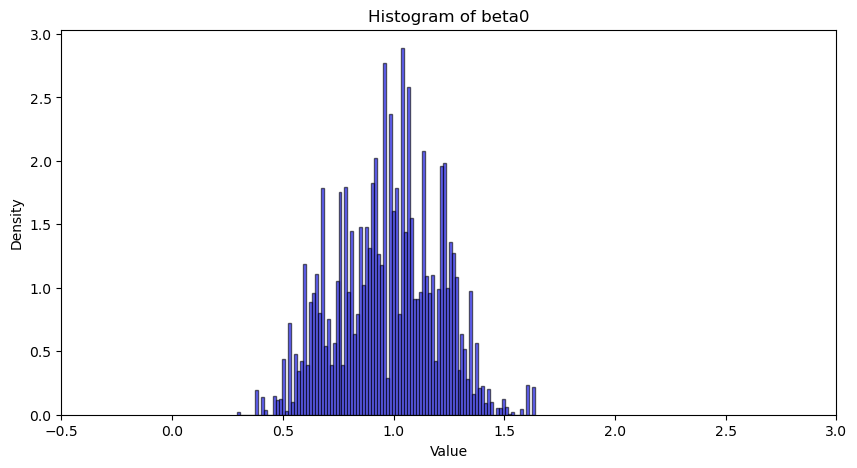

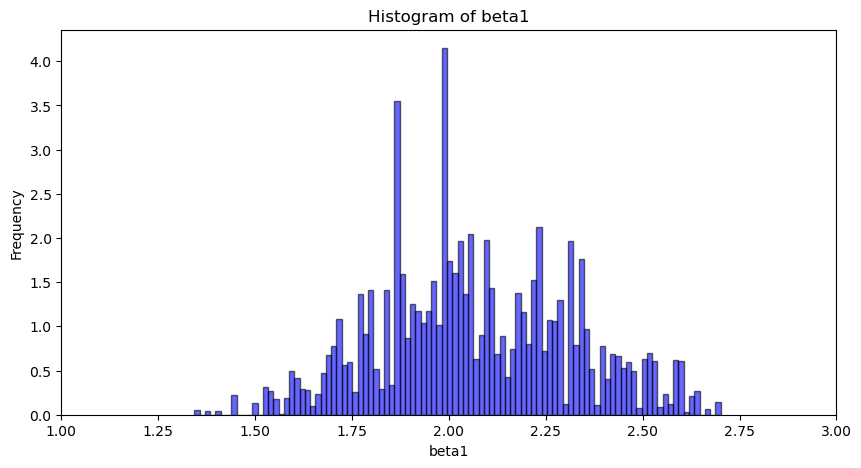

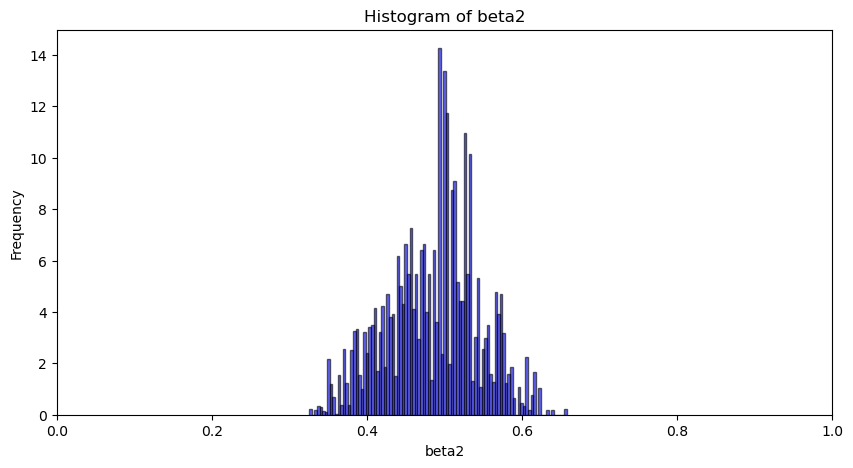

In [40]:
# Histogram for mu
plt.figure(figsize=(10, 5))
plt.hist(beta01[20000:, 0], bins=100, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xlim(-0.5, 3)  # Set x-axis limits
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of beta0')
plt.savefig("hist_mu.png")
plt.show()

# Histogram for beta1
plt.figure(figsize=(10, 5))
plt.hist(beta01[20000:, 1], bins=100, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xlim(1, 3)  # Set x-axis limits
plt.xlabel("beta1")
plt.ylabel("Frequency")
plt.title("Histogram of beta1")
plt.savefig("hist_beta1.png")
plt.show()

# Histogram for beta2
plt.figure(figsize=(10, 5))
plt.hist(beta2[20000:], bins=100, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xlim(0, 1)  # Set x-axis limits
plt.xlabel("beta2")
plt.ylabel("Frequency")
plt.title("Histogram of beta2")
plt.savefig("hist_beta2.png")
plt.show()
